In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Thu Jan 25 02:58:43 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   34C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.rand_prior import Prior
from model.latent.lse_latent import Latent
from model.quantizer.nearest_quantizer import Quantizer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [30]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_activation = F.tanh
hp.z_dim = 2
hp.n_prior_embeddings = 32
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.0

hp.M = hp.n_prior_embeddings
hp.N = 256

In [31]:
# ''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma

# p_samples1 = (torch.rand(hp.M, 2)*2-1).cuda()
# p_samples2 = (torch.rand(hp.N, 2)*2-1).cuda()
# log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2, -10, 10) for _ in range(100)])
#hp.init_log_sigma = np.median(log_sigmas)
hp.init_log_sigma = 0
print(hp.init_log_sigma)

0


In [32]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0003662109375
latent 3.814697265625e-06
quantizer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [33]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.25-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 20000, model_list, optimizer_list)

total 77184
-rw-rw-r-- 1 scpark scpark   256058  1월 25 03:08 events.out.tfevents.1706119569.GPUSVR11
-rw-rw-r-- 1 scpark scpark   871524  1월 25 03:06 events.out.tfevents.1706119128.GPUSVR11
-rw-rw-r-- 1 scpark scpark 37976107  1월 25 03:06 save_0
-rw-rw-r-- 1 scpark scpark   281024  1월 25 02:58 events.out.tfevents.1706118985.GPUSVR11
-rw-rw-r-- 1 scpark scpark   158384  1월 25 02:56 events.out.tfevents.1706118864.GPUSVR11
-rw-rw-r-- 1 scpark scpark   243940  1월 25 02:53 events.out.tfevents.1706118717.GPUSVR11
-rw-rw-r-- 1 scpark scpark   354262  1월 25 02:51 events.out.tfevents.1706118548.GPUSVR11
-rw-rw-r-- 1 scpark scpark   709157  1월 25 02:49 events.out.tfevents.1706118187.GPUSVR11
-rw-rw-r-- 1 scpark scpark 37987461  1월 25 02:47 save_3774
-rw-rw-r-- 1 scpark scpark   102812  1월 25 02:42 events.out.tfevents.1706118128.GPUSVR11
-rw-rw-r-- 1 scpark scpark    52227  1월 25 02:41 events.out.tfevents.1706118037.GPUSVR11
-rw-rw-r-- 1 scpark scpark      263  1월 25 02:40 events.out.tfevents.170

### Dataset

In [34]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


In [35]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [36]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i, :, :, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [37]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

In [38]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


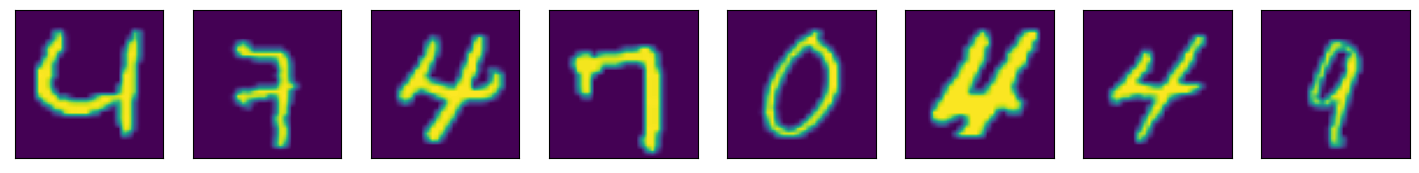

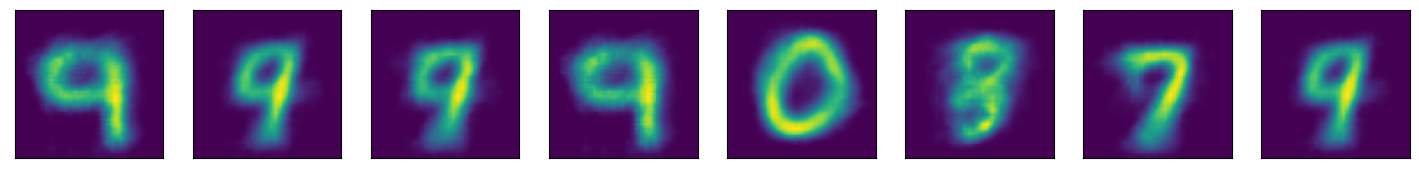

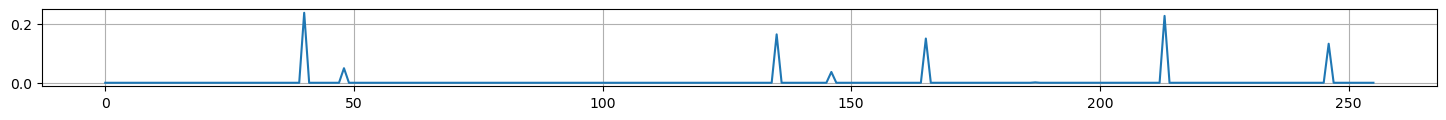

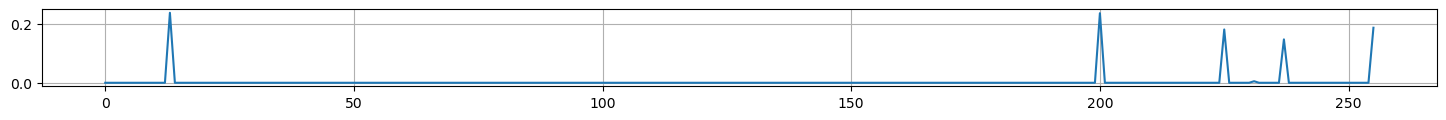

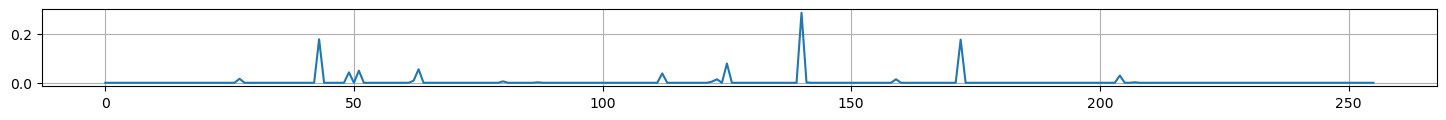

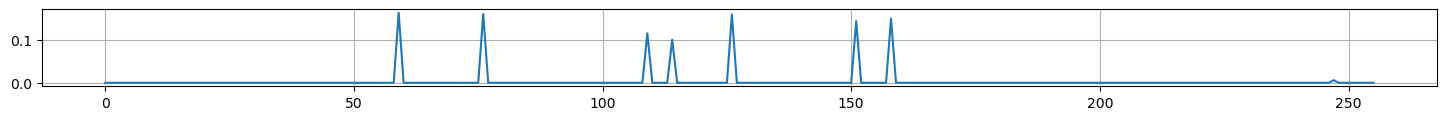

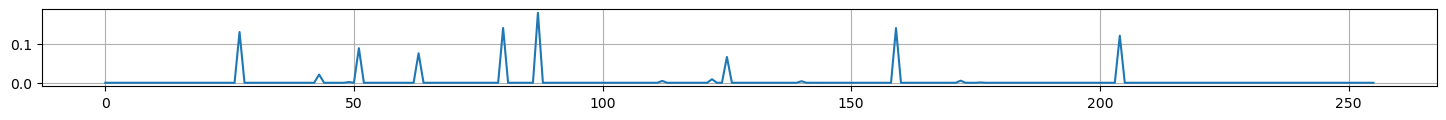

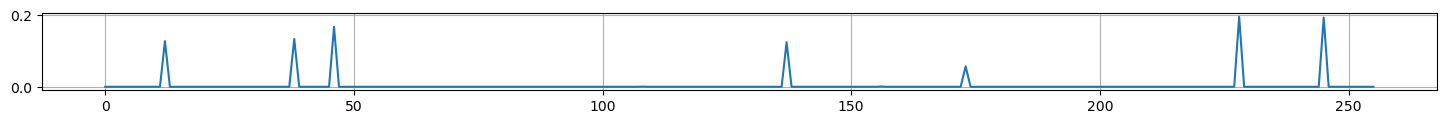

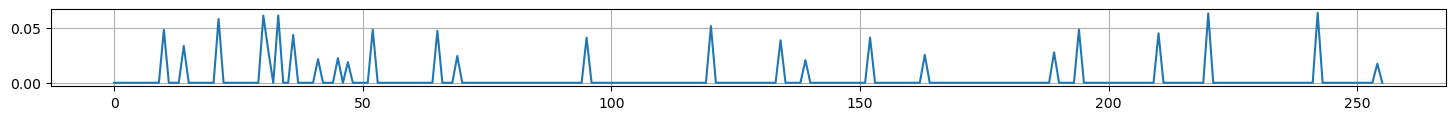

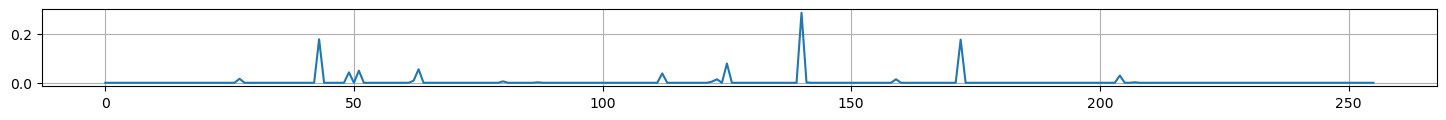

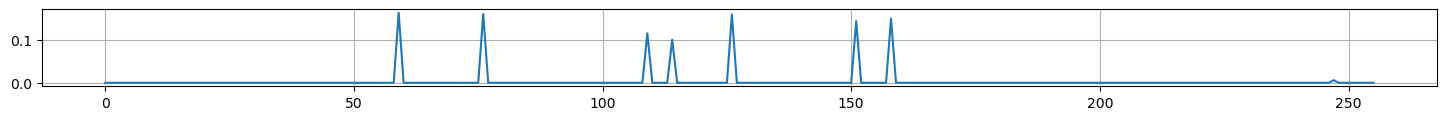

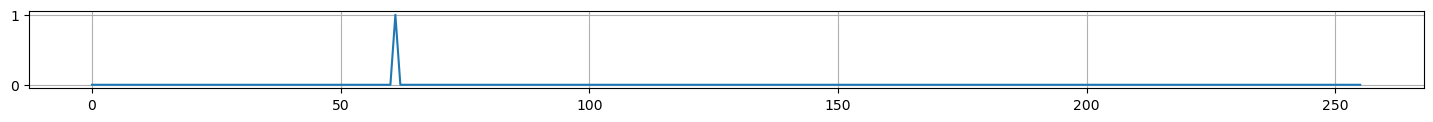

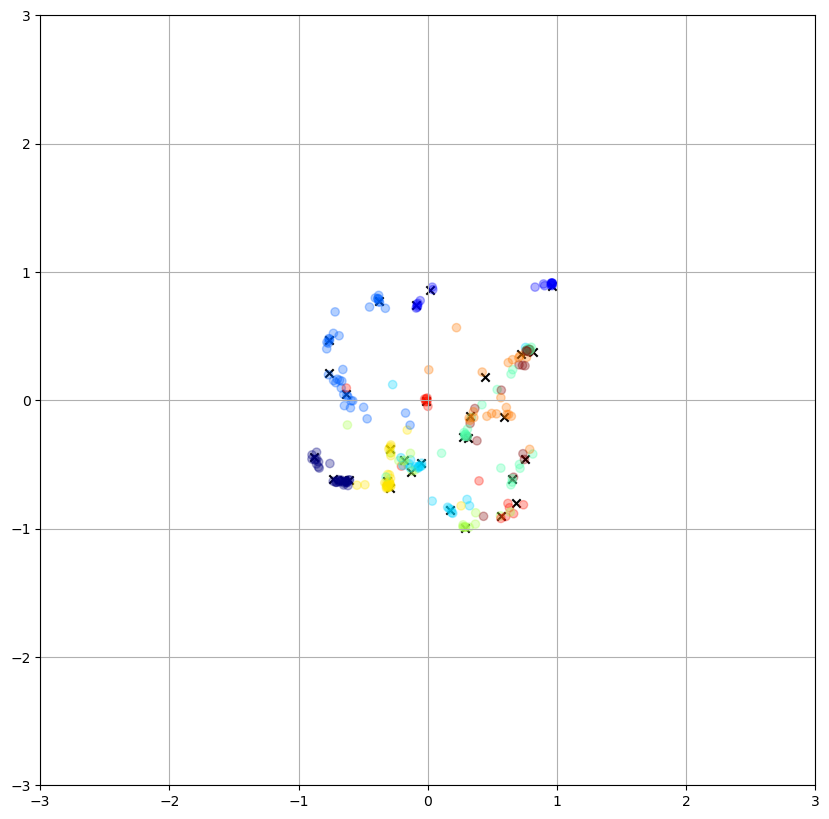

14001
lse_loss -3.6772289276123047
commit_loss 0.00237326230853796
recon_loss 0.1480015218257904
14002
lse_loss -3.009690761566162
commit_loss 0.0022669592872262
recon_loss 0.1436348408460617
14003
lse_loss -3.731088638305664
commit_loss 0.002121023600921035
recon_loss 0.14717087149620056
14004
lse_loss -3.6554718017578125
commit_loss 0.0022006691433489323
recon_loss 0.15266361832618713
14005
lse_loss -3.65615177154541
commit_loss 0.0026850132271647453
recon_loss 0.15298394858837128
14006
lse_loss -3.677827835083008
commit_loss 0.002994844689965248
recon_loss 0.14184178411960602
14007
lse_loss -3.7931289672851562
commit_loss 0.0021960516460239887
recon_loss 0.1510385274887085


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            e = model.prior.prior.data.cpu().numpy()
            z = data['z'].data.cpu().numpy()
            t = data['t'].data.cpu().numpy()
            plt.figure(figsize=[10, 10])
            plt.scatter(e[:, 0], e[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z[:, 0], z[:, 1], marker='o', alpha=0.3, c=t, cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.xlim([-3, 3])
            plt.ylim([-3, 3])
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [41]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done
